In [1]:
# loading libraries
import pandas as pd
import networkx as nx
import os
from tqdm import tqdm
import statistics
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# loading and cleaning ENSG converter
test = []
geneId_geneName = {}
with open('Homo_sapiens.GRCh37.74.gtf', 'r') as file:
    for line in file:
        line = line.strip()
        data = line.split('\t')[-1]
        test.append(data)
        if 'gene_name' in data:
            attributes = data.split(';')
            geneId = attributes[0].split(' ')[1].strip('"')
            for attr in attributes:
                if 'gene_name' in attr:
                    geneName = attr.split(' ')[2].strip('"')
                    if geneId not in geneId_geneName:
                        geneId_geneName[geneId] = geneName
geneName_geneId = {v: k for k, v in geneId_geneName.items()}

In [3]:
def createRegulatory(regulatory_filepath):
    # loading, cleaning, and permutating regulatory dataset
    print(f'Loading: {regulatory_filepath}')
    regulatory = pd.read_csv(regulatory_filepath, index_col=0)
    
    exceptions = []
    for name in regulatory.index:
        try:
            regulatory = regulatory.rename(index={name: geneName_geneId[name]})
        except:
            exceptions.append(name)
    
    print(f'Row exception count: {len(exceptions)}')
    
    for exc in exceptions:
        regulatory = regulatory.drop(exc)

    # # if columns are ENSG IDs, uncomment this part
    # exceptions = []
    # for ID in regulatory.columns.tolist():
    #     if ID not in geneId_geneName:
    #         exceptions.append(ID)

    # if columns are gene names, uncomment this part
    exceptions = []
    for name in regulatory.columns.tolist():
        try:
            regulatory = regulatory.rename(columns={name: geneName_geneId[name]})
        except:
            exceptions.append(name)

    
    print(f'Column exception count: {len(exceptions)}')

    for exc in exceptions:
        regulatory = regulatory.drop(exc)

    
    def inverse(x):
        return 1/x
    
    def absolute(x):
        return abs(x)
    
    regulatory = regulatory.map(inverse)
    regulatory = regulatory.map(absolute)

    return regulatory

def createEndpoints(filepath):
    # loading and cleaning dataset
    endpoints = pd.read_csv(filepath, sep='\t', index_col=0)
    
    exceptions = []
    for name in endpoints.index:
        try:
            endpoints = endpoints.rename(index={name: geneName_geneId[name.upper()]})
        except:
            exceptions.append(name)
    
    print(f'Endpoints exception count: {len(exceptions)}')
    
    for exc in exceptions:
        endpoints = endpoints.drop(exc)

    return list(endpoints.index)

def createRandomEndpoints(regulatory, num, seed):
    rand = regulatory.sample(n=num, random_state=seed)
    return list(rand.index)

def createGraph(regulatory, endpoints):
    # creating network
    regMatrix = regulatory.to_numpy().tolist()
    
    G = nx.Graph()
    nodes = list(set(list(regulatory.index) + regulatory.columns.tolist() + endpoints))
    G.add_nodes_from(nodes)
    edgeCount = 0
    for rowName, row in zip(regulatory.index, regMatrix):
        for columnName, cell in zip(regulatory.columns.tolist(), row):
            # if cell < 10:
            G.add_edge(rowName, columnName, weight=cell)
            edgeCount += 1
    
    print(f'EdgeCount: {edgeCount}')

    return G

def connectionEnrichment(origins, endpoints):
    datasets = os.listdir('data')
    datasets.remove('.DS_Store')
    count = {}
    for i, dataset in enumerate(datasets):
        print(i)
        regulatory = createRegulatory(f'data/{dataset}')
        G = createGraph(regulatory, endpoints)
        for origin in origins:
            for i, endpoint in enumerate(tqdm(endpoints)):
                try:
                    path = nx.shortest_path(G, origin, endpoint, weight="weight")
                    path.pop(0)
                    path.pop()
                    for node in path:
                        if node not in count:
                            count[node] = 1
                        else:
                            count[node] += 1
                except:
                    pass
    return count

def sortDic(dic):
    return dict(reversed(sorted(dic.items(), key=lambda item: item[1])))

def printResultsWithStats(dic):
    print(f'Size: {len(dic)}')
    print(f'Average: {statistics.mean(dic.values())}')
    print(f'Median: {statistics.median(dic.values())}')
    print(dic)

In [4]:
# multi-dataset aging gene enrichment
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
agingCount = connectionEnrichment(globalAgingGenes, globalAgingGenes)

Endpoints exception count: 15
0
Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
EdgeCount: 7708797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [01:00<00:00,  5.14it/s]


In [5]:
## printing results
printResultsWithStats(sortDic(agingCount))

Size: 1495
Average: 63.982608695652175
Median: 4
{'ENSG00000207869': 824, 'ENSG00000199133': 652, 'ENSG00000268097': 624, 'ENSG00000207709': 590, 'ENSG00000221028': 534, 'ENSG00000207742': 500, 'ENSG00000207746': 498, 'ENSG00000265432': 480, 'ENSG00000207810': 448, 'ENSG00000216090': 442, 'ENSG00000268031': 442, 'ENSG00000207638': 434, 'ENSG00000207728': 426, 'ENSG00000207720': 420, 'ENSG00000207698': 418, 'ENSG00000207627': 414, 'ENSG00000264066': 410, 'ENSG00000211578': 406, 'ENSG00000207839': 402, 'ENSG00000199004': 402, 'ENSG00000207695': 400, 'ENSG00000272045': 396, 'ENSG00000207559': 396, 'ENSG00000207719': 394, 'ENSG00000207952': 390, 'ENSG00000207607': 390, 'ENSG00000207613': 388, 'ENSG00000221063': 388, 'ENSG00000207602': 378, 'ENSG00000264534': 378, 'ENSG00000221261': 376, 'ENSG00000257178': 372, 'ENSG00000211590': 372, 'ENSG00000266235': 364, 'ENSG00000207693': 360, 'ENSG00000265195': 358, 'ENSG00000207626': 358, 'ENSG00000221667': 354, 'ENSG00000199080': 354, 'ENSG000002697

In [6]:
# control experiment 1
datasets = os.listdir('data')
datasets.remove('.DS_Store')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes), 42)
controlCount1 = connectionEnrichment(randomGenes, randomGenes)

Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
EdgeCount: 7708797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:30<00:00, 10.30it/s]


In [7]:
# printing results
printResultsWithStats(sortDic(controlCount1))

Size: 10259
Average: 9.351593722585047
Median: 6
{'ENSG00000114631': 88, 'ENSG00000112799': 84, 'ENSG00000160741': 80, 'ENSG00000112651': 78, 'ENSG00000168724': 78, 'ENSG00000205363': 74, 'ENSG00000198860': 72, 'ENSG00000118245': 70, 'ENSG00000099995': 70, 'ENSG00000147416': 68, 'ENSG00000219200': 64, 'ENSG00000088205': 64, 'ENSG00000113721': 62, 'ENSG00000175189': 60, 'ENSG00000132680': 60, 'ENSG00000165730': 60, 'ENSG00000178307': 58, 'ENSG00000148400': 58, 'ENSG00000260458': 58, 'ENSG00000134809': 56, 'ENSG00000213337': 56, 'ENSG00000165655': 56, 'ENSG00000187258': 56, 'ENSG00000106483': 56, 'ENSG00000155158': 56, 'ENSG00000064652': 54, 'ENSG00000137392': 54, 'ENSG00000182134': 54, 'ENSG00000089876': 54, 'ENSG00000042832': 54, 'ENSG00000075420': 52, 'ENSG00000143442': 52, 'ENSG00000164074': 52, 'ENSG00000135409': 52, 'ENSG00000151502': 52, 'ENSG00000158089': 50, 'ENSG00000129071': 50, 'ENSG00000166473': 50, 'ENSG00000272580': 50, 'ENSG00000140463': 50, 'ENSG00000025772': 50, 'ENSG00

In [8]:
# control experiment 2
datasets = os.listdir('data')
datasets.remove('.DS_Store')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes), 43)
controlCount2 = connectionEnrichment(randomGenes, randomGenes)

Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
EdgeCount: 7708797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:28<00:00, 10.71it/s]


In [9]:
# printing results
printResultsWithStats(sortDic(controlCount2))

Size: 10293
Average: 9.326143981346545
Median: 6
{'ENSG00000112799': 86, 'ENSG00000135316': 74, 'ENSG00000162961': 74, 'ENSG00000075223': 70, 'ENSG00000007038': 68, 'ENSG00000154035': 66, 'ENSG00000114631': 66, 'ENSG00000198860': 64, 'ENSG00000154845': 64, 'ENSG00000161664': 64, 'ENSG00000179335': 62, 'ENSG00000007384': 62, 'ENSG00000140650': 60, 'ENSG00000107611': 60, 'ENSG00000144935': 60, 'ENSG00000173992': 60, 'ENSG00000178307': 60, 'ENSG00000136928': 60, 'ENSG00000213337': 60, 'ENSG00000100027': 58, 'ENSG00000171574': 58, 'ENSG00000101890': 58, 'ENSG00000272580': 58, 'ENSG00000176986': 56, 'ENSG00000143742': 54, 'ENSG00000185236': 54, 'ENSG00000147416': 54, 'ENSG00000099795': 54, 'ENSG00000148400': 54, 'ENSG00000134809': 54, 'ENSG00000155158': 52, 'ENSG00000012061': 52, 'ENSG00000175189': 52, 'ENSG00000198964': 52, 'ENSG00000158805': 50, 'ENSG00000262088': 50, 'ENSG00000243646': 50, 'ENSG00000167106': 50, 'ENSG00000172689': 50, 'ENSG00000103152': 50, 'ENSG00000179111': 50, 'ENSG00

In [10]:
# control experiment 3
datasets = os.listdir('data')
datasets.remove('.DS_Store')
regulatory = createRegulatory(f'data/{datasets[0]}')
globalAgingGenes = createEndpoints('global_aging_genes.tsv')
randomGenes = createRandomEndpoints(regulatory, len(globalAgingGenes), 44)
controlCount3 = connectionEnrichment(randomGenes, randomGenes)

Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
Endpoints exception count: 15
0
Loading: data/Fibroblast_Cell_Line_miRanda_PUMA.csv
Row exception count: 166
Column exception count: 0
EdgeCount: 7708797


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:30<00:00, 10.27it/s]


In [11]:
# printing results
printResultsWithStats(sortDic(controlCount3))

Size: 10308
Average: 9.316453240201785
Median: 6.0
{'ENSG00000114631': 82, 'ENSG00000136928': 78, 'ENSG00000122557': 76, 'ENSG00000041982': 76, 'ENSG00000012061': 76, 'ENSG00000143742': 74, 'ENSG00000167272': 70, 'ENSG00000213337': 68, 'ENSG00000267229': 66, 'ENSG00000160741': 66, 'ENSG00000142102': 66, 'ENSG00000167332': 64, 'ENSG00000147416': 62, 'ENSG00000123992': 62, 'ENSG00000075420': 62, 'ENSG00000264719': 62, 'ENSG00000187513': 60, 'ENSG00000171310': 60, 'ENSG00000139540': 60, 'ENSG00000168916': 60, 'ENSG00000189058': 60, 'ENSG00000180316': 60, 'ENSG00000188883': 60, 'ENSG00000182134': 60, 'ENSG00000168899': 58, 'ENSG00000165730': 58, 'ENSG00000183077': 58, 'ENSG00000174992': 58, 'ENSG00000100156': 58, 'ENSG00000185236': 56, 'ENSG00000178307': 56, 'ENSG00000135083': 56, 'ENSG00000165655': 54, 'ENSG00000145198': 54, 'ENSG00000099995': 54, 'ENSG00000138035': 54, 'ENSG00000153093': 54, 'ENSG00000172689': 54, 'ENSG00000092148': 52, 'ENSG00000135409': 52, 'ENSG00000087111': 52, 'ENSG

Text(0.5, 0, 'Number of overlaps')

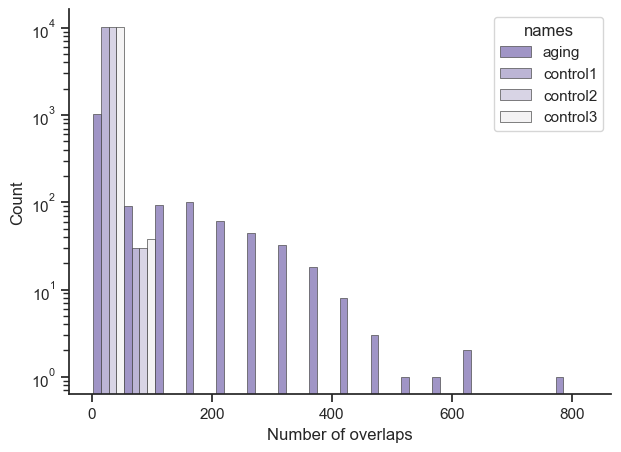

In [12]:
# creating graph
agingVal = list(agingCount.values())
controlVal1 = list(controlCount1.values())
controlVal2 = list(controlCount2.values())
controlVal3 = list(controlCount3.values())
agingName = ['aging' for i in range(len(agingVal))]
controlName1 = ['control1' for i in range(len(controlVal1))]
controlName2 = ['control2' for i in range(len(controlVal2))]
controlName3 = ['control3' for i in range(len(controlVal3))]

counts = agingVal + controlVal1 + controlVal2 + controlVal3
names = agingName + controlName1 + controlName2 + controlName3

df = pd.DataFrame({'counts': counts, 'names': names})

sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(
    df,
    x="counts", hue="names",
    multiple="dodge",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    bins = 16,
)

plt.yscale('log')
plt.xlabel("Number of overlaps")

In [13]:
for name1, dataset1 in zip(['aging', 'control1', 'control2', 'control3'], [agingCount, controlCount1, controlCount2, controlCount3]):
    print(f'Origin: {name1}')
    for name2, dataset2 in zip(['aging', 'control1', 'control2', 'control3'], [agingCount, controlCount1, controlCount2, controlCount3]):
        print(f'Endpoint: {name2}')
        intersection = set(dataset1).intersection(set(dataset2))
        sideTotal2 = sum([dataset2[i] for i in intersection])
        print(f'{len(intersection)} // {sideTotal2} // {int(sideTotal2 / len(intersection))}')

Origin: aging
Endpoint: aging
1495 // 95654 // 63
Endpoint: control1
939 // 17086 // 18
Endpoint: control2
946 // 17034 // 18
Endpoint: control3
946 // 17048 // 18
Origin: control1
Endpoint: aging
939 // 8294 // 8
Endpoint: control1
10259 // 95938 // 9
Endpoint: control2
8339 // 85076 // 10
Endpoint: control3
8135 // 83268 // 10
Origin: control2
Endpoint: aging
946 // 8954 // 9
Endpoint: control1
8339 // 85286 // 10
Endpoint: control2
10293 // 95994 // 9
Endpoint: control3
8246 // 83902 // 10
Origin: control3
Endpoint: aging
946 // 8992 // 9
Endpoint: control1
8135 // 83444 // 10
Endpoint: control2
8246 // 84118 // 10
Endpoint: control3
10308 // 96034 // 9


In [14]:
genageDF = pd.read_csv("genage_human.csv")
genageList = list(genageDF['symbol'])
genageENSGList = [geneName_geneId[name] for name in genageList]

In [15]:
# experiment
filteredAgingCount = {k:v for k,v in agingCount.items() if k in genageENSGList}
printResultsWithStats(sortDic(filteredAgingCount))

Size: 19
Average: 4.947368421052632
Median: 4
{'ENSG00000106128': 26, 'ENSG00000113721': 8, 'ENSG00000142168': 8, 'ENSG00000104365': 8, 'ENSG00000163666': 6, 'ENSG00000147133': 4, 'ENSG00000116478': 4, 'ENSG00000104884': 4, 'ENSG00000213923': 4, 'ENSG00000186868': 4, 'ENSG00000100823': 2, 'ENSG00000012061': 2, 'ENSG00000175595': 2, 'ENSG00000109971': 2, 'ENSG00000112096': 2, 'ENSG00000062822': 2, 'ENSG00000138798': 2, 'ENSG00000170899': 2, 'ENSG00000197386': 2}


In [16]:
# control 1
filteredControlCount1 = {k:v for k,v in controlCount1.items() if k in genageENSGList}
printResultsWithStats(sortDic(filteredControlCount1))

Size: 169
Average: 9.455621301775148
Median: 6
{'ENSG00000113721': 62, 'ENSG00000104884': 36, 'ENSG00000012061': 34, 'ENSG00000142168': 32, 'ENSG00000163666': 30, 'ENSG00000147133': 28, 'ENSG00000100823': 28, 'ENSG00000105723': 28, 'ENSG00000175595': 26, 'ENSG00000062822': 24, 'ENSG00000113013': 24, 'ENSG00000147168': 24, 'ENSG00000116478': 24, 'ENSG00000112096': 24, 'ENSG00000070831': 22, 'ENSG00000173757': 22, 'ENSG00000078900': 22, 'ENSG00000134900': 22, 'ENSG00000198793': 22, 'ENSG00000110245': 22, 'ENSG00000196591': 20, 'ENSG00000245848': 20, 'ENSG00000273482': 18, 'ENSG00000100038': 18, 'ENSG00000077782': 18, 'ENSG00000167244': 18, 'ENSG00000137203': 18, 'ENSG00000005421': 18, 'ENSG00000107643': 16, 'ENSG00000119950': 16, 'ENSG00000169375': 16, 'ENSG00000150907': 16, 'ENSG00000176697': 16, 'ENSG00000116044': 16, 'ENSG00000175197': 14, 'ENSG00000115317': 14, 'ENSG00000169047': 14, 'ENSG00000136936': 14, 'ENSG00000171720': 12, 'ENSG00000185591': 12, 'ENSG00000170899': 12, 'ENSG0000

In [17]:
# control 2
filteredControlCount2 = {k:v for k,v in controlCount2.items() if k in genageENSGList}
printResultsWithStats(sortDic(filteredControlCount2))

Size: 187
Average: 9.20855614973262
Median: 6
{'ENSG00000012061': 52, 'ENSG00000142168': 44, 'ENSG00000062822': 40, 'ENSG00000175595': 40, 'ENSG00000106128': 36, 'ENSG00000186868': 36, 'ENSG00000163666': 36, 'ENSG00000131747': 32, 'ENSG00000100823': 28, 'ENSG00000113721': 28, 'ENSG00000137203': 28, 'ENSG00000147168': 28, 'ENSG00000104884': 26, 'ENSG00000110245': 24, 'ENSG00000109971': 24, 'ENSG00000273482': 22, 'ENSG00000104687': 22, 'ENSG00000070831': 22, 'ENSG00000188486': 20, 'ENSG00000198176': 18, 'ENSG00000139197': 18, 'ENSG00000169047': 18, 'ENSG00000147133': 18, 'ENSG00000115317': 18, 'ENSG00000175054': 18, 'ENSG00000105329': 18, 'ENSG00000198793': 18, 'ENSG00000118046': 18, 'ENSG00000113013': 16, 'ENSG00000171720': 16, 'ENSG00000165731': 16, 'ENSG00000005421': 16, 'ENSG00000197299': 16, 'ENSG00000185591': 16, 'ENSG00000017427': 16, 'ENSG00000116478': 16, 'ENSG00000196591': 16, 'ENSG00000130203': 14, 'ENSG00000174775': 14, 'ENSG00000104432': 14, 'ENSG00000167244': 14, 'ENSG00000

In [18]:
# control 3
filteredControlCount3 = {k:v for k,v in controlCount3.items() if k in genageENSGList}
printResultsWithStats(sortDic(filteredControlCount3))

Size: 181
Average: 9.646408839779005
Median: 6
{'ENSG00000012061': 76, 'ENSG00000113721': 42, 'ENSG00000116478': 38, 'ENSG00000110245': 34, 'ENSG00000078900': 32, 'ENSG00000112096': 32, 'ENSG00000198793': 32, 'ENSG00000186868': 32, 'ENSG00000070831': 30, 'ENSG00000104884': 30, 'ENSG00000105329': 30, 'ENSG00000005421': 28, 'ENSG00000145675': 28, 'ENSG00000106268': 26, 'ENSG00000196591': 26, 'ENSG00000147168': 24, 'ENSG00000104687': 22, 'ENSG00000109971': 22, 'ENSG00000067369': 22, 'ENSG00000169375': 20, 'ENSG00000165731': 20, 'ENSG00000134900': 20, 'ENSG00000131747': 20, 'ENSG00000173267': 20, 'ENSG00000105723': 20, 'ENSG00000163666': 18, 'ENSG00000104432': 18, 'ENSG00000143799': 18, 'ENSG00000245848': 18, 'ENSG00000139197': 16, 'ENSG00000175197': 16, 'ENSG00000137203': 16, 'ENSG00000119950': 16, 'ENSG00000147883': 16, 'ENSG00000141510': 16, 'ENSG00000186951': 16, 'ENSG00000104365': 16, 'ENSG00000171720': 14, 'ENSG00000147133': 14, 'ENSG00000107643': 14, 'ENSG00000100038': 14, 'ENSG0000